https://archive.ics.uci.edu/dataset/20/census+income

income
<=50K    0.75919
>50K     0.24081
Name: proportion, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None
Initial defaul

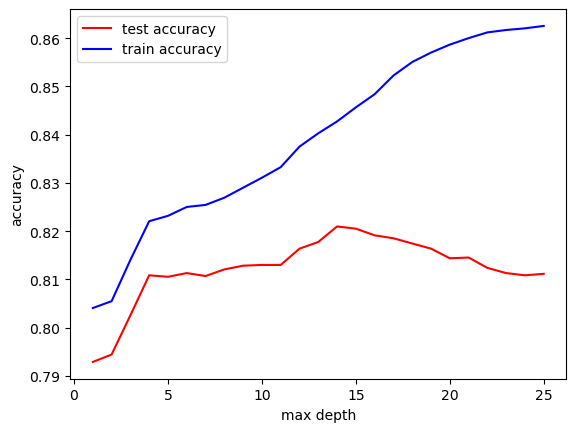

Top 5 random forest features:
          feature  importance
1    capital-gain    0.355011
0             age    0.259970
2    capital-loss    0.144690
3  hours-per-week    0.141772
4        sex_Male    0.076163
The highest accuracy on the test is achieved when depth: 9
The highest accuracy on the test set is: 84.431%


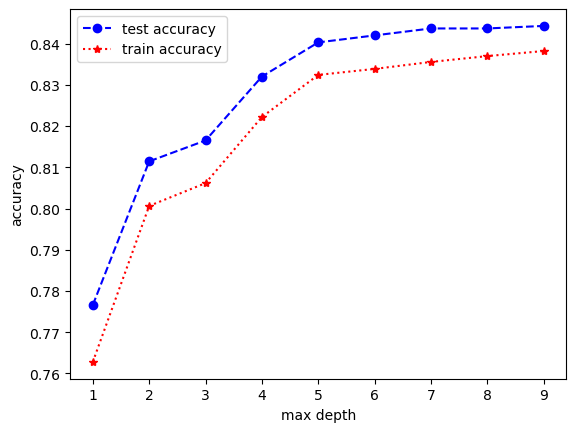

Top 5 random forest features:
          feature  importance
0             age    0.326777
3  hours-per-week    0.276717
1    capital-gain    0.166229
2    capital-loss    0.109842
4        sex_Male    0.043077


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Import models from scikit learn module:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, RandomForestRegressor
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

col_names = ['age', 'workclass', 'fnlwgt','education', 'education-num',
'marital-status', 'occupation', 'relationship', 'race', 'sex',
'capital-gain','capital-loss', 'hours-per-week','native-country', 'income']

df = pd.read_csv('adult.data', header=None, names = col_names)

#Distribution of income
print(df.income.value_counts(normalize=True))
print(df.info())

#Clean columns by stripping extra whitespace for columns of type "object"
for col in df.select_dtypes(['object']).columns:
  df[col] = df[col].str.strip()

#Create feature dataframe X with feature columns and dummy variables for categorical features
feature_cols = ['age', 'capital-gain', 'capital-loss', 'hours-per-week', 'sex','race']

X = pd.get_dummies(df[feature_cols], drop_first=True)
#Create output variable y which is binary, 0 when income is less than 50k, 1 when it is greather than 50k
y = df['income'].map({
  "<=50K": 0,
  ">50K": 1
})

#Split data into a train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=49, test_size=.20)

#Instantiate random forest classifier, fit and score with default parameters
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

print(f'Initial default RF forest score: {rf.score(X_test, y_test)}')

#Tune the hyperparameter max_depth over a range from 1-25, save scores for test and train set
np.random.seed(0)
accuracy_train = []
accuracy_test = []
depths = np.arange(1,26,1)
for depth in depths:
    rf = RandomForestClassifier(max_depth=depth)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy_test.append(accuracy_score(y_test, rf.predict(X_test)))
    accuracy_train.append(accuracy_score(y_train, rf.predict(X_train)))

    
#Find the best accuracy and at what depth that occurs
best_accuracy = np.max(accuracy_test)
best_depth = depths[np.argmax(accuracy_test)]

print(f'Best accuracy: {best_accuracy}')
print(f'Best Depth: {best_depth}')

#Plot the accuracy scores for the test and train set over the range of depth values
plt.plot(depths, accuracy_test, c='red')
plt.plot(depths, accuracy_train, c='blue')
plt.legend(['test accuracy', 'train accuracy'])
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.show()

#Save the best random forest model and save the feature importances in a dataframe
best_rf = RandomForestClassifier(max_depth=best_depth)
best_rf.fit(X_train, y_train)

feature_imp_df = pd.DataFrame(zip(X_train.columns, best_rf.feature_importances_),  columns=['feature', 'importance'])

print('Top 5 random forest features:')
print(feature_imp_df.sort_values('importance', ascending=False).iloc[0:5])

#Create two new features, based on education and native country
df['education_bin'] =  pd.cut(df['education-num'], [0,9,13,16], labels=['HS or less', 'College to Bachelors', 'Masters or more'])

feature_cols = ['age',
       'capital-gain', 'capital-loss', 'hours-per-week', 'sex', 'race','education_bin']
#Use these two new additional features and recreate X and test/train split
X = pd.get_dummies(df[feature_cols], drop_first=True)
x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=1, test_size=.2)

#Find the best max depth now with the additional two features
np.random.seed(0)

accuracy_train=[]
accuracy_test = []
depths = range(1,10)
for i in depths:
    rf = RandomForestClassifier(max_depth=i)
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_test)
    accuracy_test.append(accuracy_score(y_test, rf.predict(x_test)))
    accuracy_train.append(accuracy_score(y_train, rf.predict(x_train)))
    

#Save the best model and print the two features with the new feature set
best_acc= np.max(accuracy_test)
best_depth = depths[np.argmax(accuracy_test)]
print(f'The highest accuracy on the test is achieved when depth: {best_depth}')
print(f'The highest accuracy on the test set is: {round(best_acc*100,3)}%')
plt.figure(2)
plt.plot(depths, accuracy_test,'bo--',depths, accuracy_train,'r*:')
plt.legend(['test accuracy', 'train accuracy'])
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.show()

# Retrain with better model
best_rf = RandomForestClassifier(max_depth=9)
best_rf.fit(X_train, y_train)

feature_imp_df = pd.DataFrame(zip(X_train.columns, best_rf.feature_importances_),  columns=['feature', 'importance'])

print('Top 5 random forest features:')
print(feature_imp_df.sort_values('importance', ascending=False).iloc[0:5])